*08/23/24*
Authors: Ismael Mendoza

The purpose of this notebook is to run HMC successfully on noisy galaxy with very low number of divergences (None?)

Try broader priors and more warmup

In [1]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [2]:
import galsim 
import jax_galsim as xgalsim

2024-08-23 15:56:05.957610: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-08-23 15:56:36.220956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm

In [5]:
from functools import partial

In [6]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [7]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [8]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

In [9]:
jax.devices()

[CudaDevice(id=0)]

In [10]:
GPU = jax.devices('gpu')[0]

In [11]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [12]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [13]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

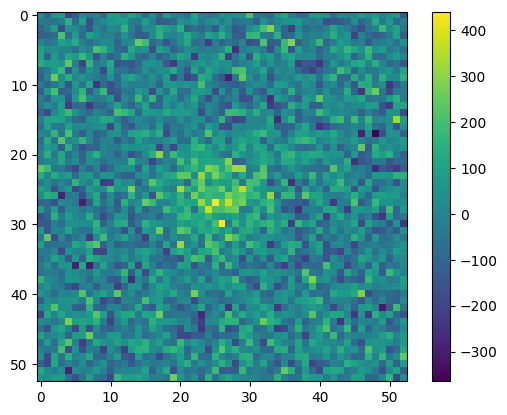

In [14]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [15]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [16]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

def draw_gal(f, hlr, g1, g2, x, y):
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=hlr)
    gal = gal.shift(dx=x, dy=y)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

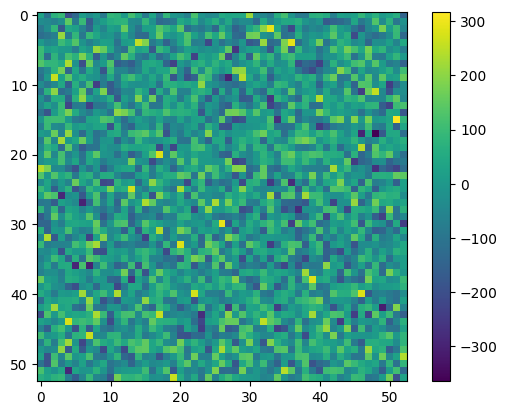

In [17]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

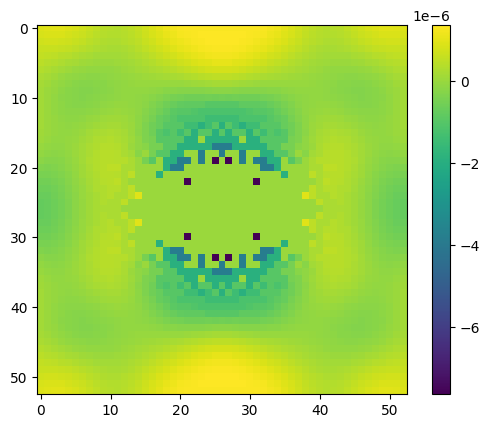

In [18]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [19]:
# # timing makes sense
# draw_gal_jitted = jax.jit(draw_gal)
# draw_gal_jitted(**TRUE_PARAMS)

# %timeit draw_gal_jitted(**TRUE_PARAMS) # ~ twice fast
# %timeit _draw_gal()

# Setup logprob

In [376]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': (-3  * PIXEL_SCALE, 3 * PIXEL_SCALE), 'y':(-3 * PIXEL_SCALE, 3 * PIXEL_SCALE)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [377]:
def transform_func(params):
    """Every variable is assumed to be uniform between (0,1)"""
    new = {} 
    for p in params:
        new[p] = params[p] * (BOUNDS_GPU[p][1] - BOUNDS_GPU[p][0]) + BOUNDS_GPU[p][0]
    return new

def inv_transform_func(params):
    """Maps variables to (0, 1)"""
    new = {} 
    for p in params:
        new[p] = (params[p] - BOUNDS_GPU[p][0]) / (BOUNDS_GPU[p][1] - BOUNDS_GPU[p][0]) 
    return new

def _logprob_fn(params, data):    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

def _logprob_fn_transform(std_params, data):
    params = transform_func(std_params)
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        prior += stats.uniform.logpdf(std_params[p], 0, 1)

             
    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

# Blackjax NUTS

In [378]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

## Warmup and divergences

In [409]:
SEED = 41
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [410]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu), backend='gpu')
_ = logdensity(TRUE_PARAMS_GPU) # executre compilation

In [411]:
_, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [412]:
warmup = blackjax.window_adaptation(
    blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False, max_num_doublings=5, 
    initial_step_size=0.1, target_acceptance_rate=0.95
)

In [413]:
init_positions = {**TRUE_PARAMS_GPU}

In [414]:
%%time
(init_states, tuned_params), adapt_info = warmup.run(warmup_key, init_positions, 1000) # rerunnig takes half time??

CPU times: user 10.9 s, sys: 184 ms, total: 11.1 s
Wall time: 11.1 s


In [415]:
tuned_params

{'step_size': Array(0.48703941, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([[ 9.50199501e-04,  8.22789550e-04,  6.37577857e-04,
          1.71058229e-03, -4.98708620e-05,  8.72371980e-06],
        [ 8.22789550e-04,  1.23202050e-02,  7.98267390e-04,
          2.70862081e-03, -5.81152513e-04,  5.63667452e-04],
        [ 6.37577857e-04,  7.98267390e-04,  1.04052750e-02,
          2.06485236e-03, -5.96238719e-04, -1.28953304e-03],
        [ 1.71058229e-03,  2.70862081e-03,  2.06485236e-03,
          6.17350666e-03, -6.66686486e-05, -1.72324279e-04],
        [-4.98708620e-05, -5.81152513e-04, -5.96238719e-04,
         -6.66686486e-05,  4.55659391e-03,  5.56513816e-06],
        [ 8.72371980e-06,  5.63667452e-04, -1.28953304e-03,
         -1.72324279e-04,  5.56513816e-06,  3.72455612e-03]],      dtype=float64),
 'max_num_doublings': 5}

### metrics

In [416]:
# DIVERGENCES
adapt_info.info.is_divergent.sum()

Array(6, dtype=int64)

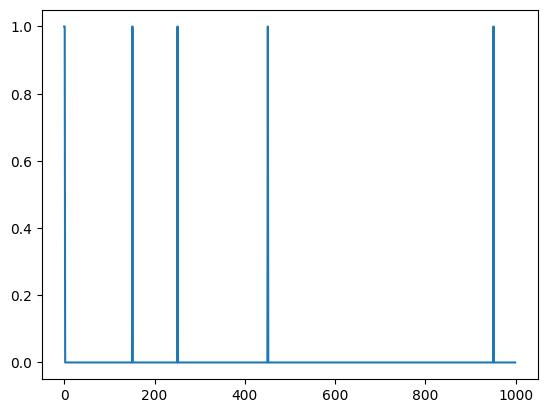

In [417]:
plt.plot(adapt_info.info.is_divergent)

(array([  6.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   3.,   1.,   1.,   2.,   3.,   9.,  20.,  33.,  44.,
         95., 195., 585.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <BarContainer object of 25 artists>)

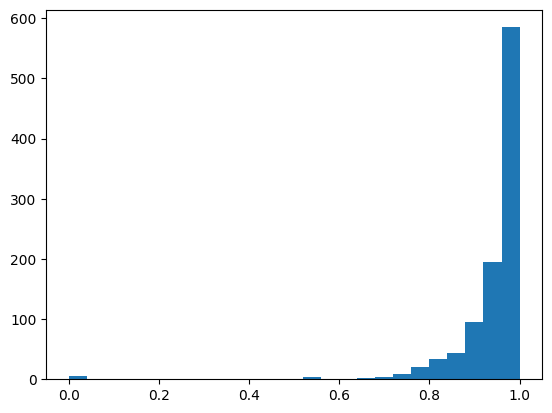

In [418]:
plt.hist(adapt_info.info.acceptance_rate, bins=25)

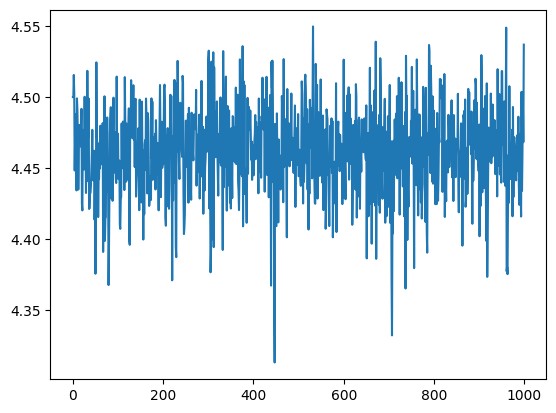

In [419]:
plt.plot(adapt_info.state.position['f'])

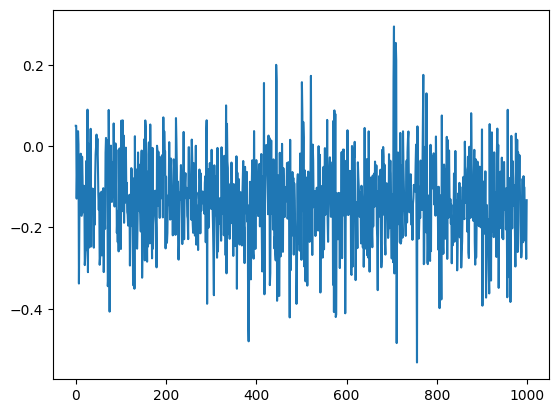

In [420]:
plt.plot(adapt_info.state.position['g1'])

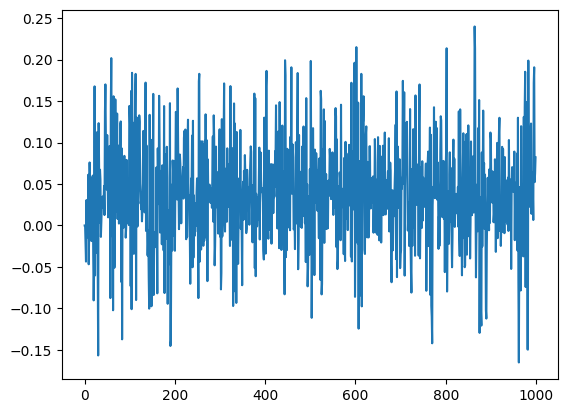

In [421]:
plt.plot(adapt_info.state.position['y'])

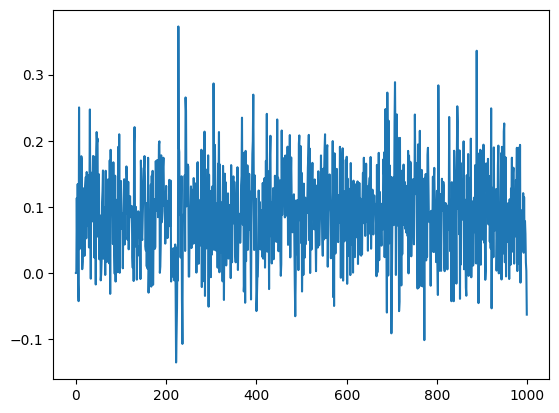

In [422]:
plt.plot(adapt_info.state.position['x'])

## Run multiple chains (same tuning)

In [423]:
# `tuned_params` and `data_gpu` from above

In [424]:
nuts = blackjax.mcmc.nuts.as_top_level_api(logdensity, **tuned_params)

In [425]:
N_CHAINS = 10
initial_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

In [426]:
%%time
### really fast even with n_chains large
states, infos = inference_loop_multiple_chains(
    sample_key, nuts.step, initial_states, n_samples=1000, n_chains=N_CHAINS
)
_ = states.position["f"].block_until_ready()

CPU times: user 11.8 s, sys: 128 ms, total: 11.9 s
Wall time: 11.5 s


In [427]:
samples = states.position

In [428]:
samples['f'].shape

(1000, 10)

### Example chains

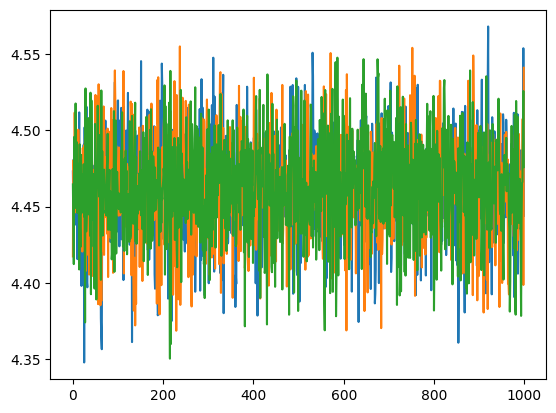

In [429]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 5])
plt.plot(samples['f'][:, 8])

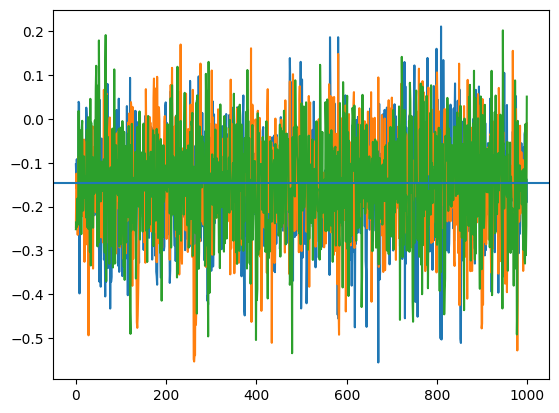

In [430]:
plt.plot(samples['g1'][:, 0])
plt.plot(samples['g1'][:, 5])
plt.plot(samples['g1'][:, 8])
plt.axhline(samples['g1'].mean())

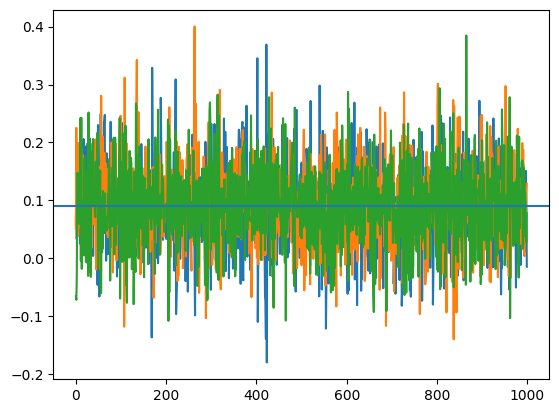

In [431]:
plt.plot(samples['x'][:, 0])
plt.plot(samples['x'][:, 5])
plt.plot(samples['x'][:, 8])
plt.axhline(samples['x'].mean())

In [432]:
infos.is_divergent.sum(-2)

Array([0, 0, 2, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

### ESS

In [433]:
# ess
print('ess')
print()
for p in samples: 
    ess = effective_sample_size(samples[p], chain_axis=1 ,sample_axis=0)
    print(p, ess)
    print('rel: %', ess * 100 / samples[p].size)
    print()
    
print()
print('r-hat')
print()
for p in samples: 
    print(p, potential_scale_reduction(samples[p], chain_axis=1 ,sample_axis=0))


ess

f 10006.41179613323
rel: % 100.0641179613323

g1 10034.834873661148
rel: % 100.34834873661147

g2 11130.294346262242
rel: % 111.30294346262242

hlr 9137.188089858011
rel: % 91.3718808985801

x 12497.292425692713
rel: % 124.97292425692713

y 13112.295615922394
rel: % 131.12295615922395


r-hat

f 1.0005183249628793
g1 1.000129559063376
g2 0.9998215534933451
hlr 1.0001323785439975
x 0.9999929120484593
y 0.9998142542606928


In [434]:
az.ess(np.array(samples['g1'].T))

10573.141287165607

In [435]:
samples['g1'].shape

(1000, 10)

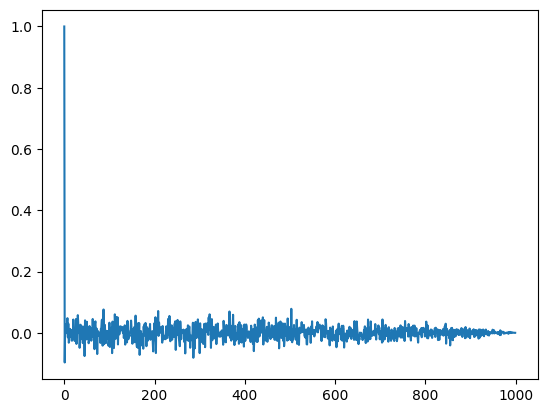

In [436]:
acr = az.autocorr(samples['g1'][:, 0])
plt.plot(acr)

### Contours

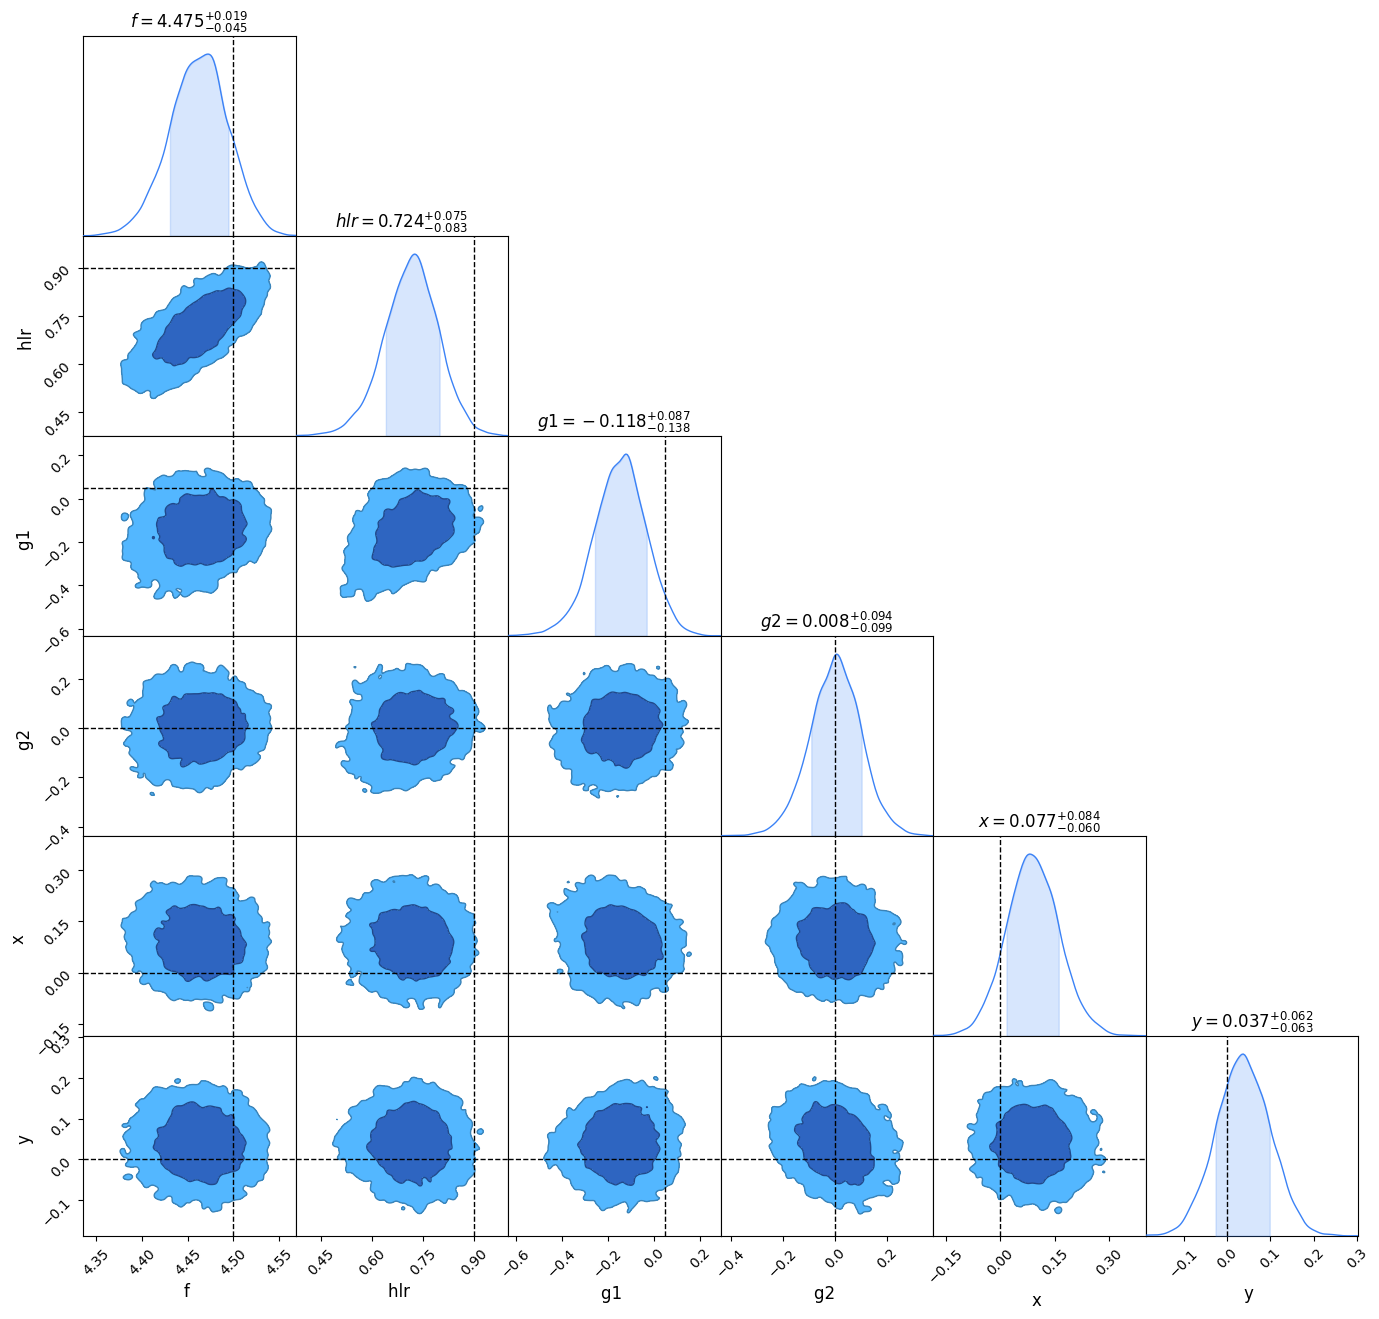

In [437]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
_samples = {k:samples[k].reshape(-1) for k in ['f', 'hlr', 'g1', 'g2', 'x', 'y']}
df =pd.DataFrame.from_dict(_samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location=TRUE_PARAMS))
fig = c.plotter.plot()

# Run warmup as a function of steps, look at metrics

In [446]:
SEED = 42
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [447]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu), backend='gpu')
_ = logdensity(TRUE_PARAMS_GPU) # executre compilation

In [448]:
_, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [453]:
warmup = blackjax.window_adaptation(
    blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False, max_num_doublings=5, 
    initial_step_size=0.1, target_acceptance_rate=0.90
)

In [454]:
init_positions = {**TRUE_PARAMS_GPU}

In [455]:
statess=[]
infoss=[]
times = []
adapt_infoss =[]

N_CHAINS = 10

n_warmups = (100, 150, 200,250, 300, 350, 400, 450, 500,600, 750, 1000)


for n_warmup in n_warmups:
    print('n_warmup', n_warmup)
    
    t1 = time.time()
    
    
    print('warmup start')
    (init_states, tuned_params), adapt_info = warmup.run(warmup_key, init_positions, 
                                                         n_warmup)
    

    
    nuts = blackjax.mcmc.nuts.as_top_level_api(logdensity, **tuned_params) # includes max_num_doublings
    kernel = jjit(nuts.step)

    
    initial_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
    initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)
    
    print('inference start')

    states, infos = inference_loop_multiple_chains(
        sample_key, kernel, initial_states, n_samples=1000, n_chains=N_CHAINS
    )
    
    t2 = time.time()
    
    print()
    
    
    statess.append(states)
    infoss.append(infos)
    times.append(t2 - t1)
    adapt_infoss.append(adapt_info)


n_warmup 100
warmup start
inference start

n_warmup 200
warmup start
inference start

n_warmup 300
warmup start
inference start

n_warmup 400
warmup start
inference start

n_warmup 500
warmup start
inference start

n_warmup 750
warmup start
inference start

n_warmup 1000
warmup start
inference start



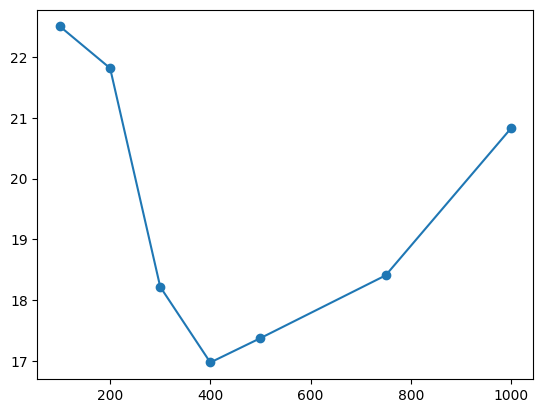

In [457]:
plt.plot(n_warmups, times, '-o')

In [459]:
divs = [info.is_divergent.sum() for info in infoss]
divs

[Array(0, dtype=int64),
 Array(0, dtype=int64),
 Array(0, dtype=int64),
 Array(0, dtype=int64),
 Array(0, dtype=int64),
 Array(0, dtype=int64),
 Array(0, dtype=int64)]

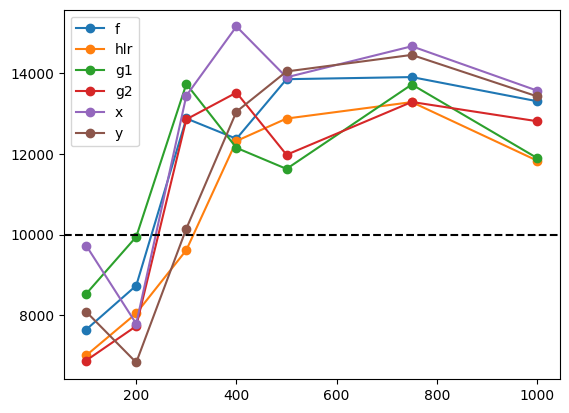

In [494]:
# 'g1'
for p in ('f', 'hlr', 'g1', 'g2', 'x', 'y'):
    esss = []

    for states in statess:
        esss.append(effective_sample_size(states.position[p], chain_axis=1, sample_axis=0))

    plt.plot(n_warmups, esss, '-o', label=p)
plt.axhline(1e4, linestyle='--', color='k')
plt.legend()

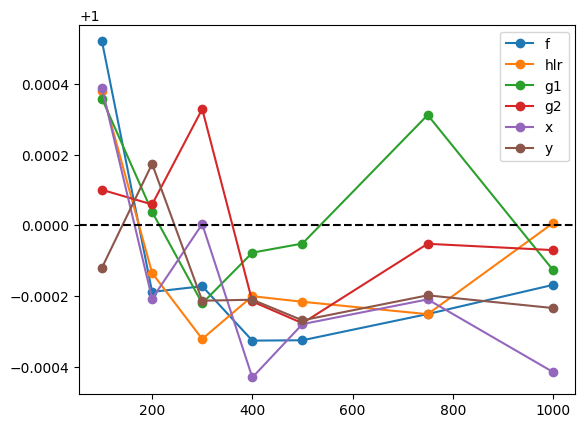

In [495]:
# 'g1'
for p in ('f', 'hlr', 'g1', 'g2', 'x', 'y'):
    rhats = []

    for states in statess:
        rhats.append(potential_scale_reduction(states.position[p], chain_axis=1, sample_axis=0))

    plt.plot(n_warmups, rhats, '-o', label=p)
plt.axhline(1, linestyle='--', color='k')
plt.legend()